## 3.4 Continous distributions

So far, we have built **empirical distributions** (which represent the distributions of values in a sample), based on observations, but many real problems are well approximated by fitting **continous distributions functions (CDF)**. 

They are called in this way because the distribution is described by an analytical continous function.

### 3.4.1 The exponential distribution

The CDF of the exponential distribution is:

$$ CDF(x) = 1 -  \exp^{- \lambda x}$$ 

And its PDF is:

$$ PDF(x) = \lambda \exp^{- \lambda x}$$

The parameter $\lambda$ determines the shape of the distribution, the mean of the distribution is $1/\lambda$ and its variance is $1/\lambda^2$. The median is $ln(2)/\lambda$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

l = 3
x=np.arange(0,2.5,0.1)
y= 1 - np.exp(-l*x)
plt.plot(x,y,'-')
plt.title('Exponential CDF: $\lambda$ =%.2f' % l ,fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('CDF',fontsize=15)
plt.show()

<Figure size 640x480 with 1 Axes>

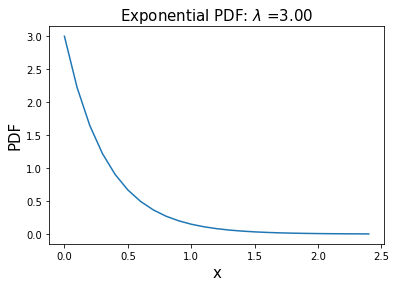

In [3]:
from __future__ import division

import scipy.stats as stats

l = 3
x=np.arange(0,2.5,0.1)
y= l * np.exp(-l*x)
plt.plot(x,y,'-')
plt.title('Exponential PDF: $\lambda$ =%.2f' % l, fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()

There are a lot of real world events that can be described with this distribution.
* The time until a radioactive particle decays,
* The time it takes before your next telephone call,
* The time until default (on payment to company debt holders) in reduced form credit risk modeling.

The random variable $X$ of the lifelengths of some batteries is associated with a probability density function of the form:

$$ PDF(x) = \frac{1}{4} \exp^{- \frac{x}{4}}$$ 

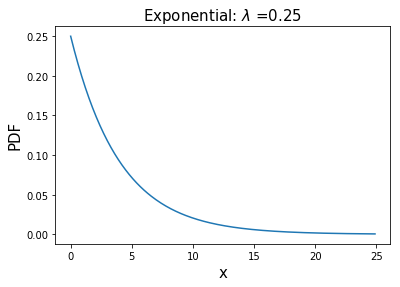

In [4]:
l = 0.25
x=np.arange(0,25,0.1)
y= l * np.exp(-l*x)
plt.plot(x,y,'-')
plt.title('Exponential: $\lambda$ =%.2f' % l ,fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.show()

### 3.4.2 The normal distribution

The **normal, or Gaussian distribution** is the most used one because it describes a lot of phenomena and because it is amenable for analysis. 

Its CDF has no closed-form expression and its more common representation is the PDF:

$$ PDF(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2} \right)$$


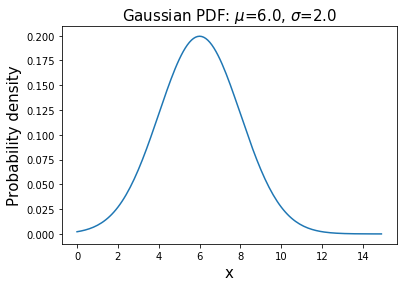

In [5]:
u=6 # mean
s=2 # standard deviation
x=np.arange(0,15,0.1)
y=(1/(np.sqrt(2*np.pi*s*s)))*np.exp(-(((x-u)**2)/(2*s*s)))
plt.plot(x,y,'-')
plt.title('Gaussian PDF: $\mu$=%.1f, $\sigma$=%.1f' % (u,s),fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('Probability density',fontsize=15)
plt.show()

Examples:
    * Measures of size of living tissue (length, height, skin area, weight);
    * The length of inert appendages (hair, claws, nails, teeth) of biological specimens, in the direction of growth; presumably the thickness of tree bark also falls under this category;
    * Certain physiological measurements, such as blood pressure of adult humans.


### 3.5 Central Limit Theorem

The normal distribution is also important, because it is involved in the Central Limit Theorem:

> Take the mean of $n$ random samples from ANY arbitrary distribution with a $well$ $defined$ standard deviation $\sigma$ and mean $\mu$. As $n$ gets bigger the **distribution of the sample mean** will always converge to a Gaussian (normal) distribution with mean $\mu$ and standard deviation $\frac{\sigma}{\sqrt{n}}$.

Colloquially speaking, the theorem states the distribution of an average tends to be normal, even when the distribution from which the average is computed is decidedly non-normal. This explains the ubiquity of the Gaussian distribution in science and statistics. 

#### Example: Uniform Distribution

The uniform distribution is obviously non-normal.  Let's call it the $parent$ $distribution$.

To compute an average, two samples are drawn ($n=2$), at random, from the parent distribution and averaged. Then another sample of two is drawn and another value of the average computed.  This process is repeated, over and over, and averages of two are computed.  

Repeatedly taking more elements ($n = 3,4...$) from the parent distribution, and computing the averages, produces a normal probability density.

C:\Users\ra407452\AppData\Local\Continuum\anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


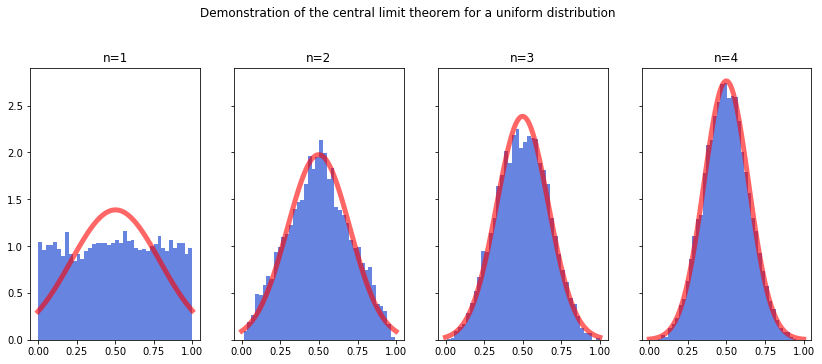

In [6]:
fig, ax = plt.subplots(1, 4, sharey=True, squeeze=True, figsize=(14, 5))
x = np.linspace(0, 1, 100)
for i in range(4):
    f = np.mean(np.random.random((10000, i+1)), 1)
    m, s = np.mean(f), np.std(f, ddof=1)
    fn = (1/(s*np.sqrt(2*np.pi)))*np.exp(-(x-m)**2/(2*s**2))  # normal pdf            
    ax[i].hist(f, 40, normed=True, color=[0, 0.2, .8, .6]) 
    ax[i].set_title('n=%d' %(i+1))
    ax[i].plot(x, fn, color=[1, 0, 0, .6], linewidth=5)
plt.suptitle('Demonstration of the central limit theorem for a uniform distribution', y=1.05)
plt.show()

## 3.6 Kernel density estimates

In some instances, we may not be interested in the parameters of a particular distribution of data, but just a **continous representation** of the data at hand. In this case, we can estimate the distribution non-parametrically (i.e. making no assumptions about the form of the underlying distribution) using kernel density estimation.

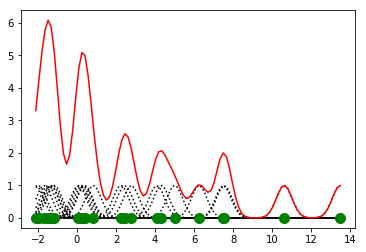

In [7]:
from scipy.stats.distributions import norm

# Some random data
y = np.random.random(15) * 10
x = np.linspace(0, 10, 100)

x1 = np.random.normal(-1, 2, 15) # parameters: (loc=0.0, scale=1.0, size=None)
x2 = np.random.normal(6, 3, 10)
y = np.r_[x1, x2] # r_ Translates slice objects to concatenation along the first axis.
x = np.linspace(min(y), max(y), 100)


# Smoothing parameter
s = 0.4

# Calculate the kernels
kernels = np.transpose([norm.pdf(x, yi, s) for yi in y])

plt.plot(x, kernels, 'k:')
plt.plot(x, kernels.sum(1), 'r')
plt.plot(y, np.zeros(len(y)), 'go', ms=10)

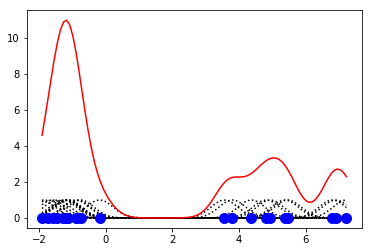

In [8]:
from scipy.stats import kde

x1 = np.random.normal(-1, 0.5, 15) # parameters: (loc=0.0, scale=1.0, size=None)
x2 = np.random.normal(6, 1, 10)
y = np.r_[x1, x2] # r_ Translates slice objects to concatenation along the first axis.
x = np.linspace(min(y), max(y), 100)

s = 0.4 # Smoothing parameter

kernels = np.transpose([norm.pdf(x, yi, s) for yi in y]) # Calculate the kernels
density = kde.gaussian_kde(y)

plt.plot(x, kernels, 'k:')
plt.plot(x, kernels.sum(1), 'r')
plt.plot(y, np.zeros(len(y)), 'bo', ms=10)

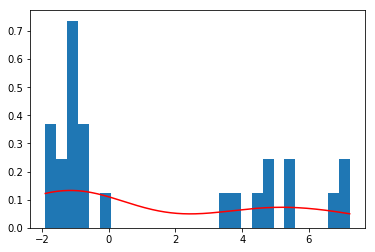

In [9]:
xgrid = np.linspace(x.min(), x.max(), 200)
plt.hist(y, bins=28, normed=True)
plt.plot(xgrid, density(xgrid), 'r-')

SciPy implements a Gaussian KDE that automatically chooses an appropriate bandwidth. Let's create a bi-modal distribution of data that is not easily summarized by a parametric distribution:

In [10]:
# Create a bi-modal distribution with a mixture of Normals.
x1 = np.random.normal(-1, 2, 15) # parameters: (loc=0.0, scale=1.0, size=None)
x2 = np.random.normal(6, 3, 10)

# Append by row
x = np.r_[x1, x2] # r_ Translates slice objects to concatenation along the first axis.


(array([0.05958008, 0.        , 0.23832034, 0.05958008, 0.05958008,
        0.        , 0.17874025, 0.05958008, 0.05958008, 0.05958008,
        0.23832034, 0.        , 0.        , 0.17874025, 0.        ,
        0.11916017, 0.        , 0.17874025]),
 array([-4.67658721, -4.00522193, -3.33385664, -2.66249136, -1.99112607,
        -1.31976079, -0.6483955 ,  0.02296978,  0.69433506,  1.36570035,
         2.03706563,  2.70843092,  3.3797962 ,  4.05116149,  4.72252677,
         5.39389205,  6.06525734,  6.73662262,  7.40798791]),
 <a list of 18 Patch objects>)

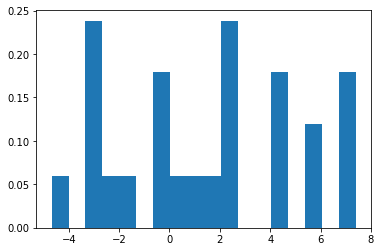

In [11]:
plt.hist(x, bins=18, normed=True)

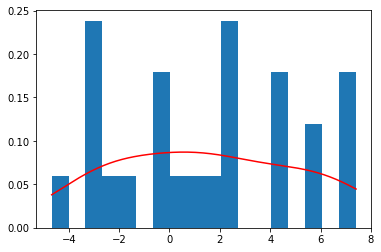

In [12]:
density = kde.gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max(), 200)
plt.hist(x, bins=18, normed=True)
plt.plot(xgrid, density(xgrid), 'r-')

<font color='black'>
## 4 Estimation


<font\> 


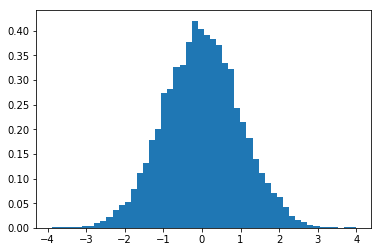

In [13]:
x = np.random.normal(0.0, 1.0, 10000)
a = plt.hist(x,50,normed='True')


**Definition:** *Estimation* is the process of inferring the parameters (e.g. mean) of a distribution from a statistic of samples drown from a population.

For example: What is the estimated mean $\hat{\mu}$ of the following normal data?

We can use our definition of empirical mean:

In [14]:
print 'The empirical mean of the sample is ', x.mean()

The empirical mean of the sample is  0.0019642840921985766


### 4.1 Sample mean

+ The process is called **estimation** and the statistic we used **estimator**.

+ The median is also an estimator (more robust to outliers). 

+ "Is median better than sample mean?" is a question with at least two different answers. We can use two different objectives to answer this question: the minimization of error or the maximization to get the right answer. 

+ If there are no outliers, we can use the **sample mean** to minimize **mean squared error** (where $m$ is the number of times you play the estimation game, not the size of the sample!):

$$ MSE = \frac{1}{m} \sum(\hat{\mu} - \mu)^2$$




In [15]:
NTs=200
mu=0.0
var=1.0
err = 0.0
NPs=1000
for i in range(NTs):
    x = np.random.normal(mu, var, NPs)
    err += (x.mean()-mu)**2

print 'MSE: ', err/NTs

MSE:  0.0008861370670577859


### 4.2 Variance

We can also estimate the variance with:

$$ \hat{\sigma}^2 = \frac{1}{n} \sum_i (x_i - \mu)^2 $$

This estimator works for large samples, but it is biased for small samples. We can use this one:

$$ \hat{\sigma}^2_{n-1} = \frac{1}{n-1} \sum_i (x_i - \mu)^2 $$


### 4.3 Other concepts: Standard scores

$$ z_i = \frac{x_i - \mu}{\sigma}$$

This measure is dimensionless and its distribution has mean 0 and variance 1.

It inherits the "shape" of $X$: if it is normally distributed, so is $Z$. If $X$ is skewed, so is $Z$.

### 4.4 Covariance

**Covariance** is a measure of the tendency of two variables to vary together. 

If we have two series $X$ and $Y$ with $X=\{x_i\}$ and $Y=\{y_i\}$, and they vary together, their deviations $x_i - \mu_X$ and $y_i - \mu_Y$ tend to have the same sign.

If we multiply them together, the product is positive, when the deviations have the same sign, and negative, when they have the opposite sign. So adding up the products gives a measure of the tendency to vary together.

Covariance is the mean of the products:

$$ Cov(X,Y) = \frac{1}{n} \sum_{i=1}^n (x_i - \mu_X)*(y_i - \mu_Y), $$

where $n$ is the length of the two series.

It is a measure that is difficult to interpret.

In [16]:
def Cov(X, Y):
    def _get_dvis(V):
        return [v - np.mean(V) for v in V]
    dxis = _get_dvis(X)
    dyis = _get_dvis(Y)
    return np.sum([x * y for x, y in zip(dxis, dyis)])/len(X)


X = [5, -1, 3.3, 2.7, 12.2]
X= np.array(X)
Y = [10, 12, 8, 9, 11]

print "Cov(X, X) = %.2f" % Cov(X, X)
print "Var(X) = %.2f" % np.var(X)

print "Cov(X, Y) = %.2f" % Cov(X, Y)

Cov(X, X) = 18.89
Var(X) = 18.89
Cov(X, Y) = 0.18


Let us create some examples of positive and negative correlations like those showing the relations of stock market with respect to the economic growth or the gasoline prices with respect to the world oil production:

In [17]:
MAXN=100

MAXN=40
X=np.array([[1,9],[3, 2], [5,3],[5.5,4],[6,4],[6.5,4],[7,3.5],[7.5,3.8],[8,4],
            [8.5,4],[9,4.5],[9.5,7],[10,9],[10.5,11],[11,11.5],[11.5,12],[12,12],[12.5,12],[13,10]])



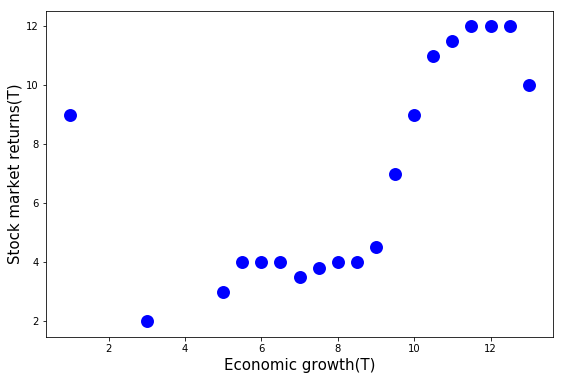

In [18]:
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='b',s=120, linewidths=2,zorder=10)
plt.xlabel('Economic growth(T)',fontsize=15)
plt.ylabel('Stock market returns(T)',fontsize=15)
plt.gcf().set_size_inches((20,6))

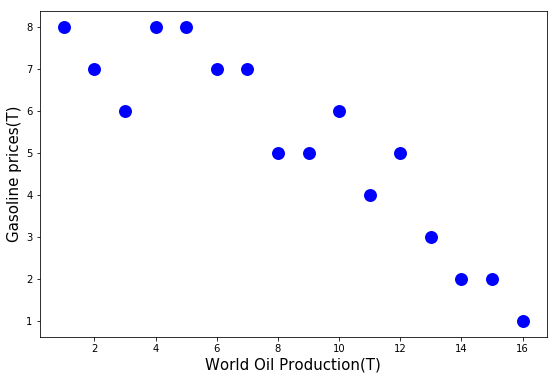

In [19]:
X=np.array([[1,8],[2, 7], [3,6],[4,8],[5,8],[6,7],[7,7],[8,5],[9,5],[10,6],[11,4],[12,5],[13,3],[14,2],[15,2],[16,1]])
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='b',s=120, linewidths=2,zorder=10)
plt.xlabel('World Oil Production(T)',fontsize=15)
plt.ylabel('Gasoline prices(T)',fontsize=15)
plt.gcf().set_size_inches((20,6))

### 4.5 Pearson's Correlation

Shell we take into account the variance? An alternative is to divide the deviations by $\sigma$, which yields standard scores, and compute the product of standard scores:

$$ p_i = \frac{(x_i - \mu_X)}{\sigma_X} \frac{(y_i - \mu_Y)}{\sigma_Y} $$
 
The mean of these products is:

$$ \rho = \frac{1}{n} \sum p_i = \frac{1}{n} \sum  \frac{(x_i - \mu_X)}{\sigma_X} \frac{(y_i - \mu_Y)}{\sigma_Y}  $$

Or we can rewrite $\rho$ by factoring out $\sigma_X$ and $\sigma_Y$:

$$ \rho = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}$$

 


In [20]:
def Corr(X, Y):
    assert len(X) == len(Y)
    return Cov(X, Y) / np.prod([np.std(V) for V in [X, Y]])

print "Corr(X, X) = %.5f" % Corr(X, X)

Y=np.random.random(len(X))

print "Corr(X, Y) = %.5f" % Corr(X, Y)

Corr(X, X) = 2.00000
Corr(X, Y) = -0.30697


When $\rho = 0$, we cannot say that there is no relationship between the variables!

Pearson's coefficient only measures **linear** correlations!

### 4.6 Spearman’s rank correlation

Pearson’s correlation works well if the relationship between variables is linear and if the variables are roughly normal. But it is not robust in the presence of **outliers**.

Spearman’s rank correlation is an alternative that mitigates the effect of outliers and skewed distributions. To compute Spearman’s correlation, we have to compute the rank of each value, which is its index in the sorted sample. 

For example, in the sample {7, 1, 2, 5} the rank of the value 5 is 3, because it appears third if we sort the elements. 

Then, we compute the Pearson’s correlation, **but for the ranks**.

ranks:  [4.0, 1.0, 2.0, 3.0]
Pearson rank coefficient: 0.28
[1.0, 2.0, 3.0, 4.0, 5.0]
[2.0, 1.0, 3.0, 5.0, 4.0]
Spearman rank coefficient: 0.80


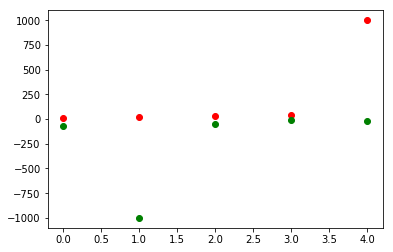

In [21]:
def list2rank(l):
    #l is a list of numbers
    # returns a list of 1-based index; mean when multiple instances
    return [np.mean([i+1 for i, sorted_el in enumerate(sorted(l)) if sorted_el == el]) for el in l]

l = [7, 1, 2, 5]
print "ranks: ", list2rank(l)

def spearmanRank(X, Y):
    # X and Y are same-length lists
    print list2rank(X) 
    print list2rank(Y)
    return Corr(list2rank(X), list2rank(Y))

X = [10, 20, 30, 40, 1000]
Y = [-70, -1000, -50, -10, -20]
plt.plot(X,'ro')
plt.plot(Y,'go')

print "Pearson rank coefficient: %.2f" % Corr(X, Y)
print "Spearman rank coefficient: %.2f" % spearmanRank(X, Y)



**Exercise:** Obtain for the Anscombe's quartet [2] given in the figures bellow, the different estimators (mean, variance, covariance for each pair, Pearson's correlation and Spearman's rank correlation.

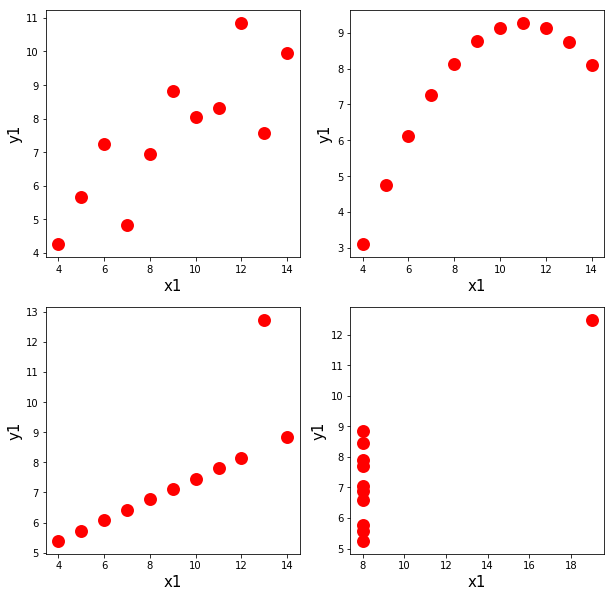

In [22]:
X=np.array([[10.0, 8.04, 10.0, 9.14, 10.0, 7.46, 8.0, 6.58],
[8.0, 6.95, 8.0, 8.14, 8.0, 6.77, 8.0, 5.76],
[13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71],
[9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84],
[11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47],
[14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04],
[6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25],
[4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50],
[12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56],
[7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91],
[5.0,5.68,5.0,4.74,5.0,5.73,8.0,6.89]])


plt.subplot(2,2,1)
plt.scatter(X[:,0],X[:,1],color='r',s=120, linewidths=2,zorder=10)
plt.xlabel('x1',fontsize=15)
plt.ylabel('y1',fontsize=15)

plt.subplot(2,2,2)
plt.scatter(X[:,2],X[:,3],color='r',s=120, linewidths=2,zorder=10)
plt.xlabel('x1',fontsize=15)
plt.ylabel('y1',fontsize=15)

plt.subplot(2,2,3)
plt.scatter(X[:,4],X[:,5],color='r',s=120, linewidths=2,zorder=10)
plt.xlabel('x1',fontsize=15)
plt.ylabel('y1',fontsize=15)

plt.subplot(2,2,4)
plt.scatter(X[:,6],X[:,7],color='r',s=120, linewidths=2,zorder=10)
plt.xlabel('x1',fontsize=15)
plt.ylabel('y1',fontsize=15)
plt.gcf().set_size_inches((10,10))